# GDSC Volunteer Program 
## TensorFlow Task

## Author: Anirudh Roy

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.sparse import csr_matrix

### Loading the dataset

In [3]:
header = ['user_id','proj_id','rating','timestamp']
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
dataset = pd.read_csv(url , sep = '\t', names = header)
dataset.head()

,user_id,proj_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [80]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.proj_id = dataset.proj_id.astype('category').cat.codes.values

In [81]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [83]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [84]:
n_users, n_project = len(dataset.user_id.unique()), len(dataset.proj_id.unique())
n_latent_factors = 20

### Defining Layers

In [102]:
proj_input = keras.layers.Input(shape=[1],name='Item')
proj_embedding = keras.layers.Embedding(n_project + 1, n_latent_factors, name='Project-Embedding')(proj_input)
proj_vec = keras.layers.Flatten(name='Flattenproject')(proj_embedding)
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
prod = keras.layers.dot([proj_vec, user_vec], axes=1,name='DotProduct')
model = keras.Model([user_input, proj_input], prod)

In [103]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [104]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Project-Embedding (Embedding)   (None, 1, 20)        33660       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        18880       User[0][0]                       
____________________________________________________________________________________________

In [106]:
history = model.fit([train.user_id, train.proj_id], train.rating, epochs=100, verbose=0)

Text(0, 0.5, 'Training Error')

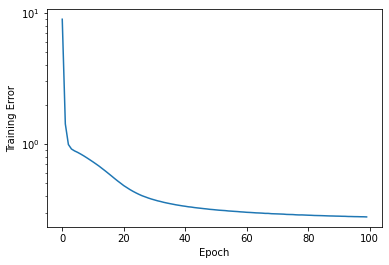

In [93]:
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [94]:
results = model.evaluate((test.user_id, test.proj_id), test.rating, batch_size=1)

20000/20000 [==============================] - 20s 979us/step - loss: 1.7077 - mae: 0.9798 - mse: 1.7077


In [97]:
proj_embedding_learnt = model.get_layer(name='Project-Embedding').get_weights()[0]

In [98]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]

In [99]:
def recommend(user_id, number_of_proj=5):
  projects = user_embedding_learnt[user_id]@proj_embedding_learnt.T
  mids = np.argpartition(projects, -number_of_proj)[-number_of_proj:]
  return mids

In [107]:
recommend(user_id=2) #the user id can be changed

array([ 984,  766,  159, 1204,  843])